In this notebook, we start training some preliminary models! 

### imports and setup

In [42]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import sys 
sys.path.append("..")
# this is so that we can import modules from other sibling packages; this is bad practice but we don't need this when we actually run python files as modules directly, it's only a problem for jupyter notebooks for some reason

In [45]:
from utils.jraph_data import get_lorenz_graph_tuples, print_graph_fts
from utils.jraph_training import rollout_loss, train_step, train_step_fn, evaluate_model, train_and_evaluate, create_dataset #, rollout_loss_batched, 
from utils.jraph_models import MLPBlock
from utils.jraph_vis import plot_predictions
# import optax
from flax.training import train_state
from datetime import datetime

import numpy as np
import jax.numpy as jnp
import jax
import os
import shutil


In [47]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

### get configs

In [48]:
from configs import GNBlock_baseline, GNBlock_overfit

## GNBlock

### overfit on small dataset

In [53]:
from configs import GNBlock_overfit
logger.setLevel(logging.INFO)
config_gnblock_overfit = GNBlock_overfit.get_config()
workdir_gnblock_overfit=f"outputs/GNBlock_overfit"
shutil.rmtree(workdir_gnblock_overfit)
trained_state = train_and_evaluate(config=config_gnblock_overfit, 
                                   workdir=workdir_gnblock_overfit)

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'add_self_loops': True, 'add_undirected_edges': True, 'add_virtual_node': True, 'b': 10, 'batch_size': 3, 'c': 10, 'checkpoint_every_epochs': 10, 'dropout_rate': 0.1, 'edge_features': (32, 16, 8), 'epochs': 500, 'eval_every_epochs': 10, 'global_features': None, 'h': 1, 'init_buffer_samples': 100, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.001, 'log_every_epochs': 1, 'model': 'MLPBlock', 'n_samples': 20, 'node_features': (32, 64, 32, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 0, 'output_steps': 4, 'sample_buffer': -4, 'seed': 42, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Obtaining datasets.
INFO:absl:Initializing network.
INFO:absl:
+-----------------------------+----------+-------+----------+-------+
| Name                        | Shape    | Size  | Mean     | Std   |
+-----------------------------+----------+-------

init_epoch 0


INFO:absl:[14] train_loss=0.9558245539665222
INFO:absl:Checkpoint.save() ...
INFO:absl:[14] val_loss=0.814987063407898
INFO:absl:[14] test_loss=0.8045699596405029
INFO:absl:Checkpoint.save() finished after 0.02s.
INFO:absl:[28] train_loss=0.8463868498802185
INFO:absl:[42] train_loss=0.8491169810295105
INFO:absl:[56] train_loss=0.8712053894996643
INFO:absl:[70] train_loss=0.8386011123657227
INFO:absl:[84] train_loss=0.8053807020187378
INFO:absl:[98] train_loss=0.7736835479736328
INFO:absl:[112] train_loss=0.7615407109260559
INFO:absl:[126] train_loss=0.757696270942688
INFO:absl:[140] train_loss=0.752884030342102
INFO:absl:[154] train_loss=0.763484001159668
INFO:absl:Checkpoint.save() ...
INFO:absl:[154] val_loss=0.6130194664001465
INFO:absl:[154] test_loss=0.5712202787399292
INFO:absl:Checkpoint.save() finished after 0.01s.
INFO:absl:[168] train_loss=0.7270973920822144
INFO:absl:[182] train_loss=0.7349979281425476
INFO:absl:[196] train_loss=0.7187544703483582
INFO:absl:[210] train_loss=

compared to the training_prelim_old notebook where we did not use negative sample buffers (so the samples were not consecutive and overlapping, but spaced apart) the losses here appear to be lower. this makes sense because there's essentially a smaller distribution/less variability in the data and it is continuously reinforced with the consecutive, overlapping data fed in. 

~~this basically allows the training to "cheat" - because on the second sample, we already know what comes after the first data point because it was in the output winow of the first sample.~~

~~we might be able to ameliorate this by having really huge output delays. but even then there is still a bit of an information leak.~~

wait - the overlapping might make it easier during training but it should have no impact during val/test time because what it sees during val/test cannot be memorized by affecting params (params aren't updated). so we should be fine. 

however, having consecutive/overlapping data makes it easier for us to plot the outcomes and have it look like the actual lorenz simulation. 

tradeoffs - does the redundant 

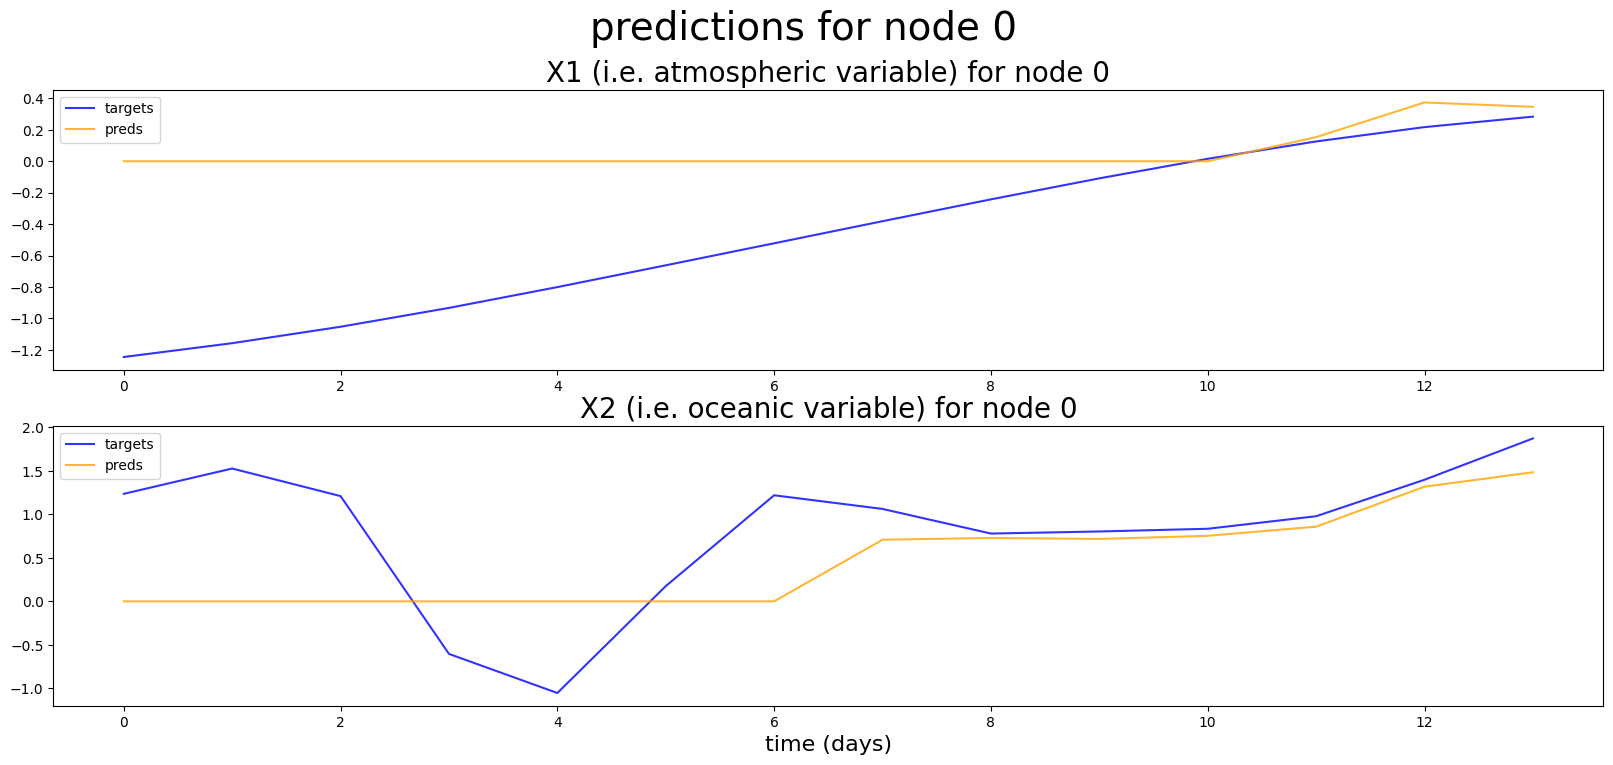

In [50]:
logger.setLevel(logging.WARNING)
plot_predictions(
    config=config_gnblock_overfit, 
    workdir=workdir_gnblock_overfit, 
    plot_ith_rollout_step=0, 
    node=0)

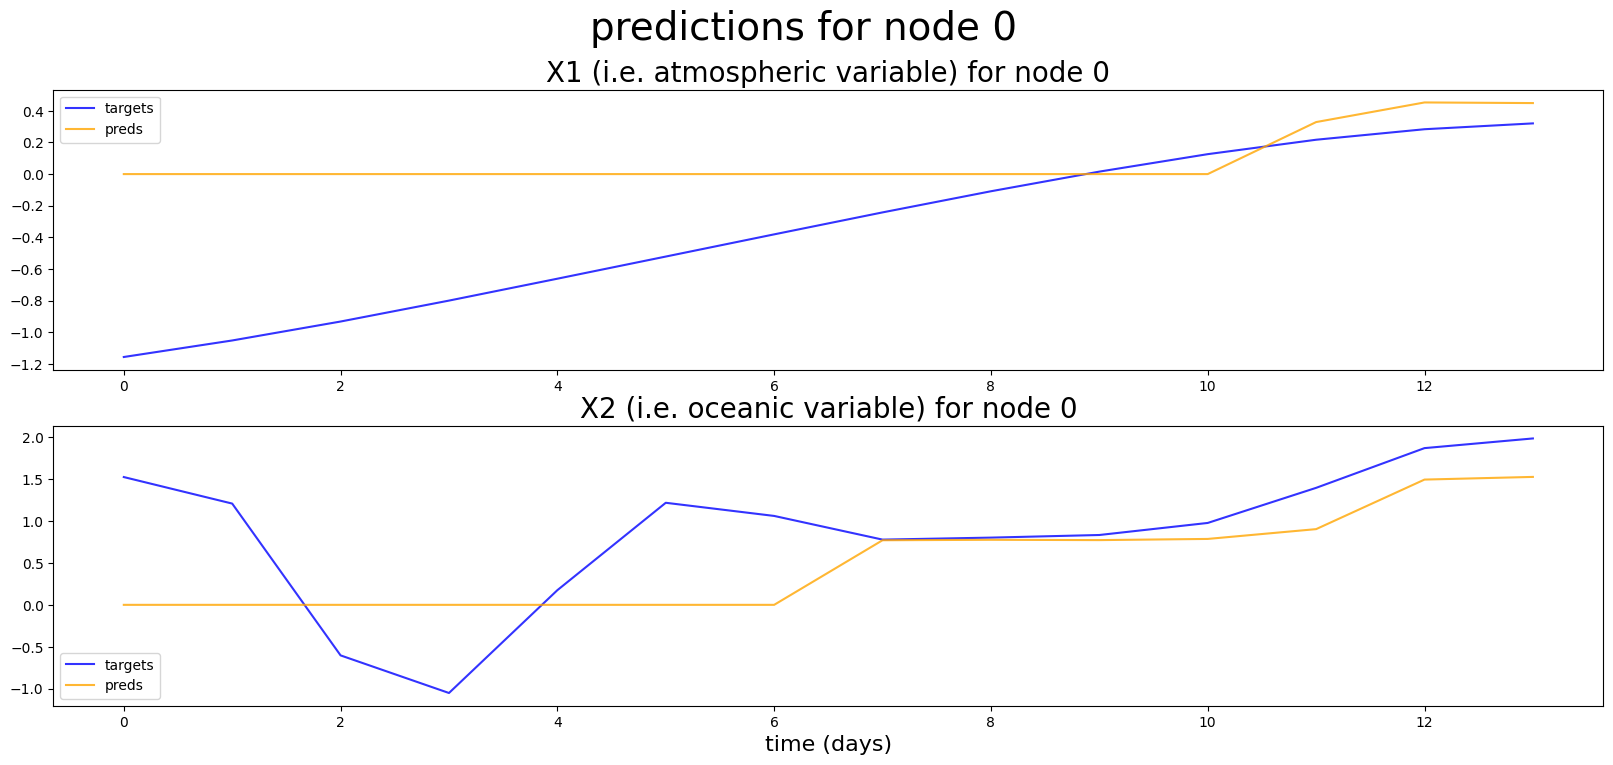

In [51]:
logger.setLevel(logging.WARNING)
plot_predictions(
    config=config_gnblock_overfit, 
    workdir=workdir_gnblock_overfit, 
    plot_ith_rollout_step=1, 
    node=0)

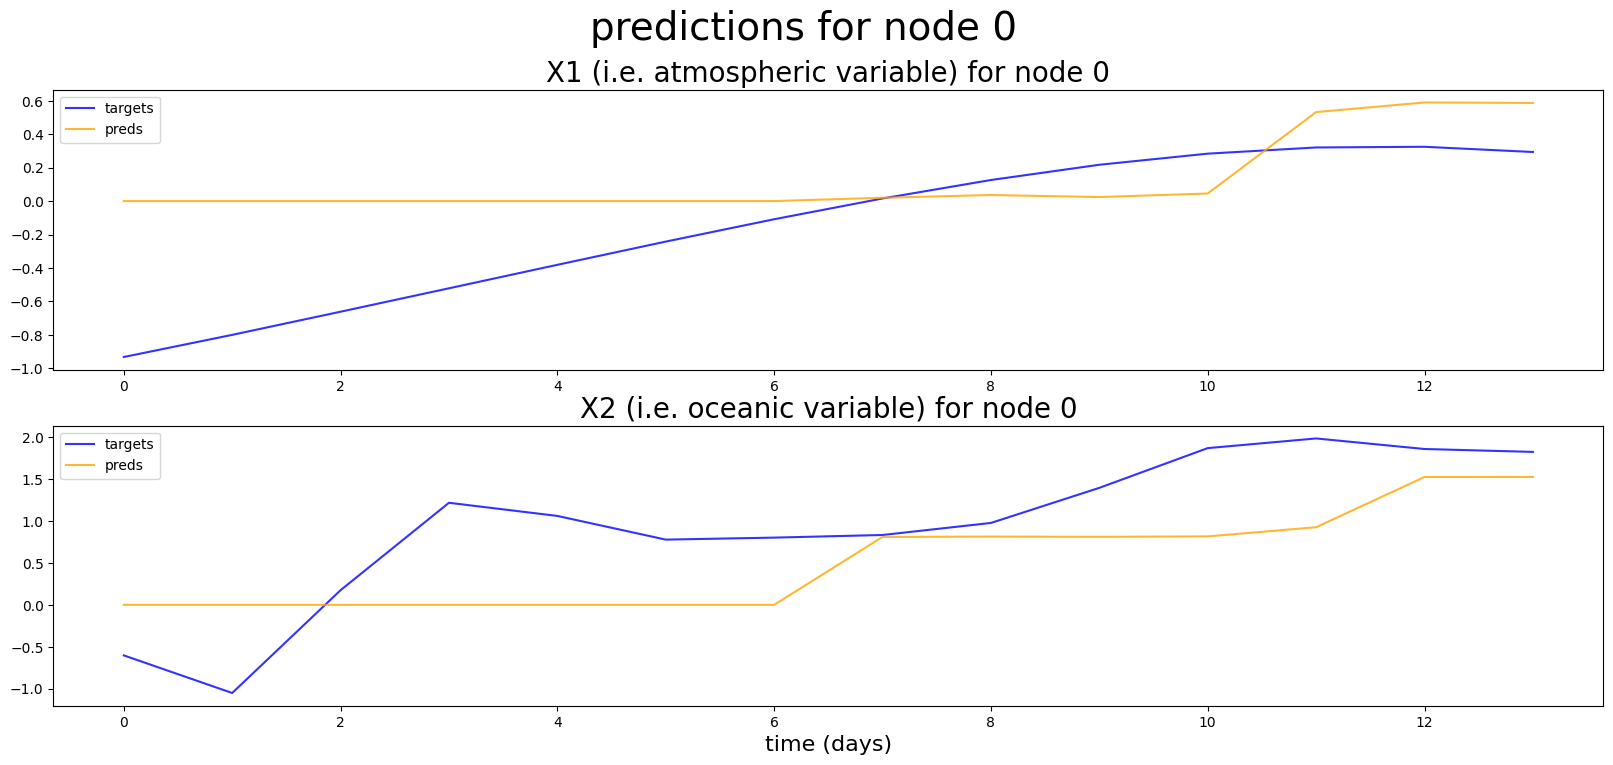

In [52]:
logger.setLevel(logging.WARNING)
plot_predictions(
    config=config_gnblock_overfit, 
    workdir=workdir_gnblock_overfit, 
    plot_ith_rollout_step=3, 
    node=0)

### run training for basic baseline

In [77]:
logger.setLevel(logging.INFO)
config_basic_gnblock = GNBlock_baseline.get_config()
workdir_basic_gnblock=f"outputs/basic_gnblock"
try:
    shutil.rmtree(workdir_basic_gnblock)
except:
    pass
trained_state = train_and_evaluate(config=config_basic_gnblock, 
                                   workdir=workdir_basic_gnblock)

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'add_self_loops': True, 'add_undirected_edges': True, 'add_virtual_node': True, 'b': 10, 'batch_size': 3, 'c': 10, 'checkpoint_every_epochs': 10, 'dropout_rate': 0.1, 'edge_features': (4, 8), 'epochs': 200, 'eval_every_epochs': 10, 'global_features': None, 'h': 1, 'init_buffer_samples': 100, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.001, 'log_every_epochs': 1, 'model': 'MLPBlock', 'n_samples': 10000, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 8, 'output_steps': 4, 'sample_buffer': -12, 'seed': 42, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Obtaining datasets.
INFO:absl:Initializing network.
INFO:absl:
+-----------------------------+----------+------+---------+-------+
| Name                        | Shape    | Size | Mean    | Std   |
+-----------------------------+----------+------+---------+---

init_epoch 0


INFO:absl:Created artifact [10] Profile of type ArtifactType.URL and value None.
INFO:absl:[7000] train_loss=0.9190818667411804
INFO:absl:Checkpoint.save() ...
INFO:absl:[7000] val_loss=0.7556290626525879
INFO:absl:[7000] test_loss=0.7791470289230347
INFO:absl:Checkpoint.save() finished after 0.01s.
INFO:absl:[14000] train_loss=0.8595904111862183
INFO:absl:[21000] train_loss=0.8445201516151428
INFO:absl:[28000] train_loss=0.8340035080909729
INFO:absl:[35000] train_loss=0.8302021622657776
INFO:absl:[42000] train_loss=0.8281393647193909
INFO:absl:[49000] train_loss=0.8248528838157654
INFO:absl:[56000] train_loss=0.8252755999565125
INFO:absl:[63000] train_loss=0.8263275027275085
INFO:absl:[70000] train_loss=0.8232269883155823
INFO:absl:Setting work unit notes: 1184.5 steps/s, 5.1% (71071/1400000), ETA: 18m (1m : 0.0% checkpoint, 1.9% eval)
INFO:absl:[71071] steps_per_sec=1184.512482
INFO:absl:[77000] train_loss=0.8234094381332397
INFO:absl:[77000] val_loss=0.7142834663391113
INFO:absl:Che

KeyboardInterrupt: 

In [87]:
logger.setLevel(logging.INFO)
plot_predictions(
    config=config_basic_gnblock, 
    workdir=workdir_basic_gnblock, 
    plot_ith_rollout_step=0, 
    node=0,
    plot_all=False,
    )

INFO:root:Obtaining datasets.


KeyboardInterrupt: 

INFO:root:Obtaining datasets.
INFO:root:Initializing network.
INFO:absl:
+-----------------------------+----------+------+---------+-------+
| Name                        | Shape    | Size | Mean    | Std   |
+-----------------------------+----------+------+---------+-------+
| params/MLP_0/Dense_0/bias   | (4,)     | 4    | 0.0     | 0.0   |
| params/MLP_0/Dense_0/kernel | (6, 4)   | 24   | -0.058  | 0.351 |
| params/MLP_0/Dense_1/bias   | (8,)     | 8    | 0.0     | 0.0   |
| params/MLP_0/Dense_1/kernel | (4, 8)   | 32   | -0.117  | 0.526 |
| params/MLP_1/Dense_0/bias   | (32,)    | 32   | 0.0     | 0.0   |
| params/MLP_1/Dense_0/kernel | (19, 32) | 608  | -0.0168 | 0.222 |
| params/MLP_1/Dense_1/bias   | (2,)     | 2    | 0.0     | 0.0   |
| params/MLP_1/Dense_1/kernel | (32, 2)  | 64   | 0.0125  | 0.175 |
+-----------------------------+----------+------+---------+-------+
Total: 774
INFO:absl:Checkpoint.restore_or_initialize() ...
INFO:absl:Restoring checkpoint: outputs/basic_gnblo

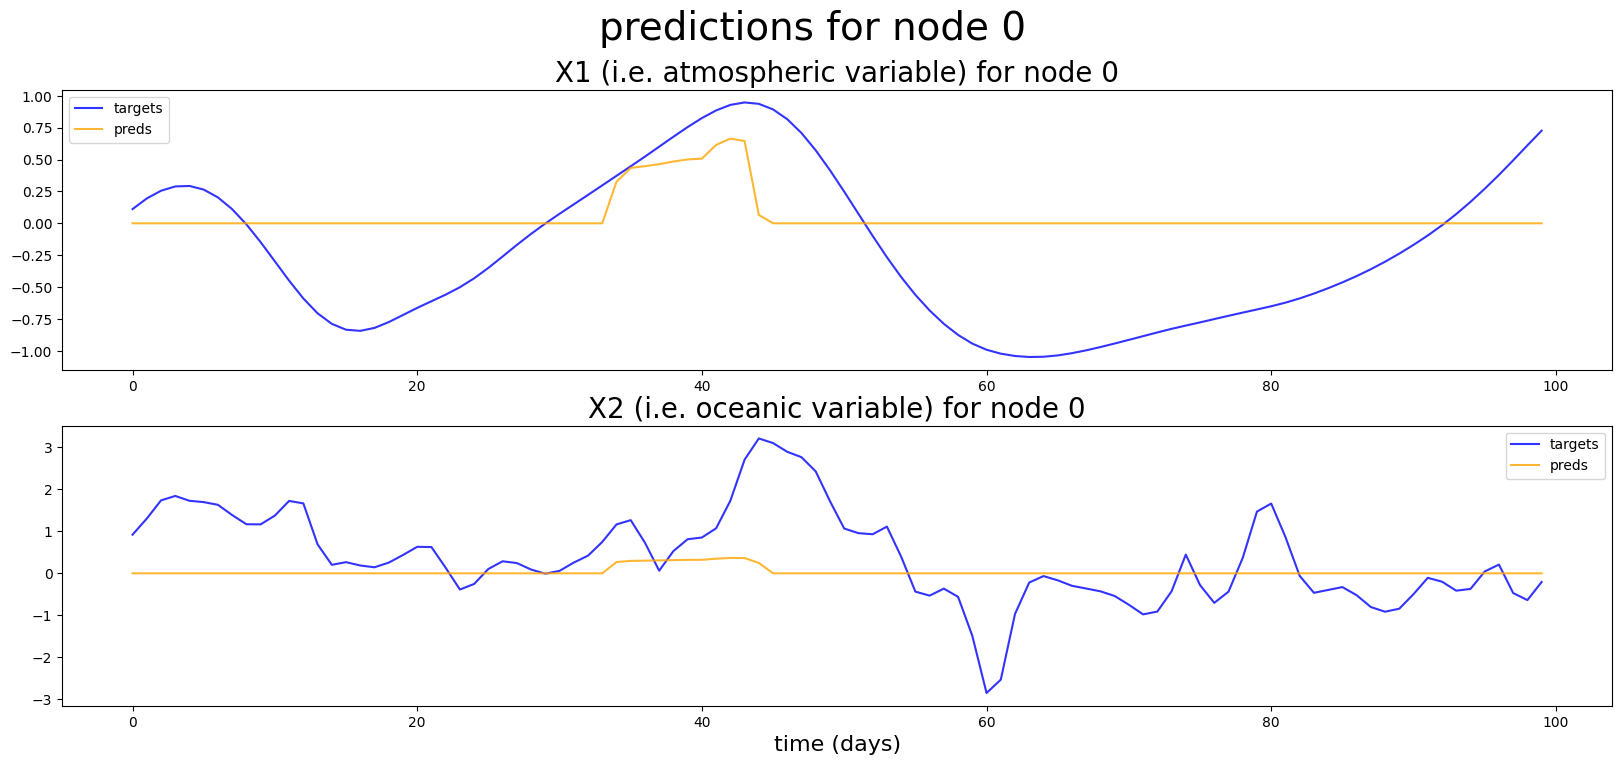

In [86]:
logger.setLevel(logging.INFO)
plot_predictions(
    config=config_basic_gnblock, 
    workdir=workdir_basic_gnblock, 
    plot_ith_rollout_step=3, 
    node=0,
    plot_all=False)

wow. somehow it is not predicting any negative values, it appears? 

### run training for bigger model

In [22]:
logger.setLevel(logging.INFO)
from configs import GNBlock_bigger
config_gnblock_bigger = GNBlock_bigger.get_config()
workdir_gnblock_bigger=f"outputs/gnblock_bigger"
try:
    shutil.rmtree(workdir_gnblock_bigger)
except:
    pass
trained_state = train_and_evaluate(config=config_gnblock_bigger, 
                                   workdir=workdir_gnblock_bigger)

KeyboardInterrupt: 

### run training for ?

## GNCore

### overfit

In [ ]:
from configs import GNCore9_overfit
config_gncore9_overfit = GNCore9_overfit.get_config()
workdir_gncore9_overfit=f"outputs/gncore9_overfit"
try:
    shutil.rmtree(workdir_gncore9_overfit)
except:
    pass
trained_state = train_and_evaluate(config=config_gncore9_overfit, 
                                   workdir=workdir_gncore9_overfit)

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'add_self_loops': True, 'add_undirected_edges': True, 'add_virtual_node': True, 'b': 10, 'batch_size': 3, 'c': 10, 'checkpoint_every_epochs': 10, 'dropout_rate': 0.1, 'edge_features': (4, 8), 'epochs': 200, 'eval_every_epochs': 10, 'global_features': None, 'h': 1, 'init_buffer_samples': 100, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.001, 'log_every_epochs': 1, 'model': 'MLPGraphNetwork', 'n_blocks': 9, 'n_samples': 20, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 0, 'output_steps': 4, 'sample_buffer': 7, 'seed': 42, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Obtaining datasets.
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   

wow. somehow this is really not training at all. it's way worse than just a single GN block. 

### overfit with 2 blocks

In [ ]:
from configs import GNCore2_overfit
config_gncore2_overfit = GNCore2_overfit.get_config()
workdir_gncore2_overfit=f"outputs/gncore2_overfit"
try:
    shutil.rmtree(workdir_gncore2_overfit)
except:
    pass
trained_state = train_and_evaluate(config=config_gncore2_overfit, 
                                   workdir=workdir_gncore2_overfit)

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'add_self_loops': True, 'add_undirected_edges': True, 'add_virtual_node': True, 'b': 10, 'batch_size': 3, 'c': 10, 'checkpoint_every_epochs': 10, 'dropout_rate': 0.1, 'edge_features': (4, 8), 'epochs': 200, 'eval_every_epochs': 10, 'global_features': None, 'h': 1, 'init_buffer_samples': 100, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.001, 'log_every_epochs': 1, 'model': 'MLPGraphNetwork', 'n_blocks': 2, 'n_samples': 20, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 0, 'output_steps': 4, 'sample_buffer': 7, 'seed': 42, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Obtaining datasets.
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   

this is doing better, more comparable to the 1 block version now. 

we should test a 1 block version to make sure that it gives the same results as if we used only a single block by itself

### GN core 1 block

theoretically this should be comparable with GNBlock_baseline

In [ ]:
from configs import GNCore1_overfit
config_gncore1_overfit = GNCore1_overfit.get_config()
workdir_gncore1_overfit=f"outputs/gncore1_overfit"
try:
    shutil.rmtree(workdir_gncore1_overfit)
except:
    pass
trained_state = train_and_evaluate(config=config_gncore1_overfit, 
                                   workdir=workdir_gncore1_overfit)

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'add_self_loops': True, 'add_undirected_edges': True, 'add_virtual_node': True, 'b': 10, 'batch_size': 3, 'c': 10, 'checkpoint_every_epochs': 10, 'dropout_rate': 0.1, 'edge_features': (4, 8), 'epochs': 200, 'eval_every_epochs': 10, 'global_features': None, 'h': 1, 'init_buffer_samples': 100, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.001, 'log_every_epochs': 1, 'model': 'MLPGraphNetwork', 'n_blocks': 1, 'n_samples': 20, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 0, 'output_steps': 4, 'sample_buffer': 7, 'seed': 42, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Obtaining datasets.
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   

interesting... somehow it is doing slightly better than GNBlock_baseline, when we expected it to perform about the same. after all, it's basically the same exact function/model...

### GN core 2 block bigger overfit

In [ ]:
from configs import GNCore2_bigger_overfit
config_gncore2_bigger_overfit = GNCore2_bigger_overfit.get_config()
workdir_gncore2_bigger_overfit=f"outputs/GNCore2_bigger_overfit"
try:
    shutil.rmtree(workdir_gncore2_bigger_overfit)
except:
    pass
trained_state = train_and_evaluate(config=config_gncore1_overfit, 
                                   workdir=workdir_gncore1_overfit)

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'add_self_loops': True, 'add_undirected_edges': True, 'add_virtual_node': True, 'b': 10, 'batch_size': 3, 'c': 10, 'checkpoint_every_epochs': 10, 'dropout_rate': 0.1, 'edge_features': (4, 8), 'epochs': 200, 'eval_every_epochs': 10, 'global_features': None, 'h': 1, 'init_buffer_samples': 100, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.001, 'log_every_epochs': 1, 'model': 'MLPGraphNetwork', 'n_blocks': 1, 'n_samples': 20, 'node_features': (32, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 0, 'output_steps': 4, 'sample_buffer': 7, 'seed': 42, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Obtaining datasets.
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+----------+------+----------+-------+
| Name                                   | Shape    | Size | Mean     | Std   

### GN similar to graphweather (overfit)

In [ ]:
from configs import graphweather_style_overfit
config_graphweather_style_overfit = graphweather_style_overfit.get_config()
workdir_graphweather_style_overfit=f"outputs/graphweather_style_overfit"
try:
    shutil.rmtree(workdir_graphweather_style_overfit)
except:
    pass
trained_state = train_and_evaluate(config=config_graphweather_style_overfit, 
                                   workdir=workdir_graphweather_style_overfit)

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'add_self_loops': True, 'add_undirected_edges': True, 'add_virtual_node': True, 'b': 10, 'batch_size': 3, 'c': 10, 'checkpoint_every_epochs': 10, 'dropout_rate': 0.1, 'edge_features': (32, 8), 'epochs': 200, 'eval_every_epochs': 10, 'global_features': None, 'h': 1, 'init_buffer_samples': 100, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.001, 'log_every_epochs': 1, 'model': 'MLPGraphNetwork', 'n_blocks': 9, 'n_samples': 20, 'node_features': (128, 128, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 0, 'output_steps': 4, 'sample_buffer': 7, 'seed': 42, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Obtaining datasets.
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+------------+--------+-----------+--------+
| Name                                   | Shape      | Size   | 

wow this is really bad. this is like not training at all    

### graphweather style, 1000 samples

In [ ]:
from configs import graphweather_style
config_graphweather_style = graphweather_style.get_config()
workdir_graphweather_style=f"outputs/graphweather_style"
try:
    shutil.rmtree(workdir_graphweather_style)
except:
    pass
trained_state = train_and_evaluate(config=config_graphweather_style, 
                                   workdir=workdir_graphweather_style)

INFO:absl:Hyperparameters: {'F': 8, 'K': 36, 'add_self_loops': True, 'add_undirected_edges': True, 'add_virtual_node': True, 'b': 10, 'batch_size': 3, 'c': 10, 'checkpoint_every_epochs': 10, 'dropout_rate': 0.1, 'edge_features': (32, 8), 'epochs': 200, 'eval_every_epochs': 10, 'global_features': None, 'h': 1, 'init_buffer_samples': 100, 'input_steps': 1, 'layer_norm': False, 'learning_rate': 0.001, 'log_every_epochs': 1, 'model': 'MLPGraphNetwork', 'n_blocks': 9, 'n_samples': 1000, 'node_features': (128, 128, 2), 'normalize': True, 'optimizer': 'adam', 'output_delay': 0, 'output_steps': 4, 'sample_buffer': 7, 'seed': 42, 'share_params': False, 'skip_connections': False, 'test_pct': 0.1, 'time_resolution': 120, 'timestep_duration': 3, 'train_pct': 0.7, 'val_pct': 0.2}
INFO:absl:Obtaining datasets.
INFO:absl:Initializing network.
INFO:absl:
+----------------------------------------+------------+--------+-----------+--------+
| Name                                   | Shape      | Size   

KeyboardInterrupt: 

ending early because it's just so bad